## Import libraries

In [9]:
import os
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import date
import yfinance as yf
from sklearn.linear_model import LinearRegression
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
import plotly
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [10]:
from platform import python_version
print('*'*30)
print('Required library version: \nPython == 3.7.4\nPandas == 0.25.1\nNumpy == 1.16.5\nMatplotlib == 3.1.1\nSeaborn == 0.9.0')
print('*'*30)
print('Current running version: \nPython == {}\nPandas == {} \nNumpy == {} \nMatplotlib == {}\nSeaborn == {}'
      .format(python_version(),pd.__version__,np.__version__,matplotlib.__version__, sns.__version__))

******************************
Required library version: 
Python == 3.7.4
Pandas == 0.25.1
Numpy == 1.16.5
Matplotlib == 3.1.1
Seaborn == 0.9.0
******************************
Current running version: 
Python == 3.7.4
Pandas == 1.0.3 
Numpy == 1.18.1 
Matplotlib == 3.1.3
Seaborn == 0.10.1


## Define functions

In [11]:
def validate_input(data_index):
    '''
    data_index: index daily price
    output: return validated input date
    '''
    while True:
        try:
            inp = input("Please input a valid date in format - YYYYMMDD: ")
            inp_dt = dt.strptime(inp, "%Y%m%d")
            min_dt, max_dt = data_index.index.min(), data_index.index.max()
            min_dt_fmt = dt.strftime(min_dt,"%m/%d/%Y")
            max_dt_fmt = dt.strftime(max_dt,"%m/%d/%Y")
            if (min_dt<=inp_dt<=max_dt):
                if inp_dt in data_index.index:
                    break;
                else:
                    dt.strftime(min_dt,"%m/%d/%Y")
                    print("{} is not a mkt open date.".format(dt.strftime(inp_dt,"%A, %m/%d/%Y")))
            else:
                print("{} is out of date range {} - {}.".format(dt.strftime(inp_dt,"%m/%d/%Y"), min_dt_fmt, max_dt_fmt))
        except ValueError:
            print("{} is not a valid date!".format(inp))
    return inp_dt;

def annulized_return(data):
    '''
    data: daily price data
    output: holding period annualized return 
    '''""
    N = len(data)
    output = ((data.iloc[-1]/data.iloc[0])**(252/N)-1) * 100;
    return output;

def cumulative_rets(data):
    '''
    data: daily price data
    output: holding period cumulative returns
    '''
    output = (data.pct_change().dropna()+1).cumprod()*100
    return output

def sharpe_ratio(data):
    '''
    data: daily price data
    output: holding period Sharpe ratio 
    '''
    hp_return = annulized_return(data) 
    hp_rf = 2                        
    hp_std = realized_vol(data)
    output = ((hp_return-hp_rf)/hp_std);
    return output;

def max_drawdown(data_series):
    '''
    data: Series daily price data
    output: holding period Maximum drawdown
    '''
    np_data = data_series.values
    end = np.argmax((np.maximum.accumulate(np_data)-np_data)/np.maximum.accumulate(np_data))
    start = np.argmax(np_data[:end])
    output = -np.round(np_data[end]/np_data[start] - 1, 4)*100
    return output;

def drawdown(data):
    '''
    data: daily price data
    output: holding period drawdown
    '''
    data_cum = cumulative_rets(data)
    running_max=np.maximum.accumulate(data_cum)
    running_max[running_max < 100] = 100
    output = data_cum/running_max - 1
    return output;

def realized_vol(data):
    '''
    data: daily price data
    output: holding period annualized realized volatility
    '''
    N = len(data)
    output = data.pct_change().dropna().std()*np.sqrt(252)*100
    return output;

def value_at_risk(data_series,var_level=5):
    '''
    data: Series daily price data
    output: holding period value at risk
    '''   
    data_d_pct = data_series.pct_change().dropna()
    output = np.percentile(data_d_pct, var_level)*100
    return output;

def bull_bear_beta (data):
    '''
    data: daily price data
    output: holding period bull and bear beta, benchmark: SPXTR
    '''   
    dt_pct = data.pct_change().dropna()
    rets_pos = dt_pct[dt_pct.iloc[:,0]>0]
    rets_neg = dt_pct[dt_pct.iloc[:,0]<=0]
    col_num = dt_pct.shape[1]
    pos_list=list()
    neg_list=list()
    x_pos = rets_pos.iloc[:,0].values.reshape(-1,1)
    x_neg = rets_neg.iloc[:,0].values.reshape(-1,1)

    for i in range(col_num-1):        
        y_pos = rets_pos.iloc[:,i+1].values        
        y_neg = rets_neg.iloc[:,i+1].values        
        reg_pos_coef = LinearRegression().fit(x_pos,y_pos).coef_ 
        pos_list.append(float(reg_pos_coef))
        reg_neg_coef = LinearRegression().fit(x_neg,y_neg).coef_
        neg_list.append(float(reg_neg_coef))      
    output = pd.DataFrame([pos_list,neg_list])   
    output.index=['Bull','Bear']
    output.columns=[dt_pct.columns[1:]]
    return output

def compare_perf(data):
    '''
    data: daily stock price
    calculate and visualize performance 
    '''
    data_len,col_n = data.shape
    min_date,max_date = data.index.min(), data.index.max()
    cum_rets_hp = cumulative_rets(data)
    
    gs = gridspec.GridSpec(9, 10)   
    plt.figure(figsize=(16,10))
    
    ax = plt.subplot(gs[1:5, :]) 
    ticker_list = data.columns
#     color_list=['#3c505c','#357cd8','#86bc6c']
    for i in range(col_n):
        plt.plot(cum_rets_hp.index,cum_rets_hp.iloc[:,i], label = ticker_list[i])
            
    plt.title('Cumulative Growth (Holding Period: {} - {}) '.
              format(dt.strftime(min_date,"%m/%d/%Y"),dt.strftime(max_date,"%m/%d/%Y")), fontsize=20)
    plt.legend(fontsize=16)
    ttl = ax.title
    ttl.set_position([.5, 1.05])
    plt.tight_layout()
    
    ax = plt.subplot(gs[6:, 2:5]) 
    np.set_printoptions(suppress=True) 
    cum_rets = cumulative_rets(data).iloc[-1,:]
    annu_rets = annulized_return(data)
    annu_vol = realized_vol(data)
#     drow_dn = drawdown(data).iloc[-1,:]
    drawdn_list=[]
    for col in data.columns:
        drawdn_list.append(max_drawdown(data[col]))
    drawdn = pd.Series(drawdn_list,index=cum_rets.index)
    shp_ration = sharpe_ratio(data)
    var_list = []
    for i in range(len(data.columns)):
        var_list.append(value_at_risk(data.iloc[:,i]))
    var5 = pd.Series(var_list,index=cum_rets.index) 
    data1 = np.round(np.array([cum_rets,annu_rets,annu_vol,shp_ration,drawdn,var5]),2)
    
    n_rows = len(data1)
    columns = tuple(data.columns.to_list())
    rows = ['%s' % x for x in ('Cumu. Growth ($)', 'Annu. Return (%)', 'Annu. Risk (%)', 'Sharpe Ratio', 'Max Drawdown (%)', '5% daily VaR (%)')]
    colors = plt.cm.BuPu(np.linspace(0, 0.5, len(rows)))

    the_table1 = plt.table(cellText=data1,
                          rowLabels=rows,
                          rowColours=colors,
                          colLabels=columns,
                          loc='center')
    the_table1.set_fontsize(14)
    the_table1.scale(1, 2)
    plt.tick_params(axis='both', which='both', bottom='off', top='off', 
    labelbottom='off', right='off', left='off', labelleft='off')
    ax.axis('tight')
    ax.axis('off')
    plt.title('Performance Statistics',fontsize=18)
    plt.tight_layout()
    
    ax = plt.subplot(gs[6:, 6:9]) 
    vol = realized_vol(data).round(2)
    ret = annulized_return(data).round(2)
#     color_list=['#3c505c','#357cd8','#86bc6c']
    lable_list = vol.index.to_list()
    for x, y, l in zip(vol, ret, lable_list):
        plt.scatter(x, y, marker = '^',s =200, label = l)
    plt.title('Risk-adjusted Return', fontsize=20)
    plt.xlabel('Annualized Risk', fontsize=14)
    plt.ylabel('Annualized Return', fontsize=14)
    plt.legend(loc='lower right',fontsize = 'large')
    plt.tight_layout()
    plt.savefig("performance.svg", dpi=150)
    
def interactive_plot(data):
    '''
    data: cumulative returns
    display cumulative returns of entire date range 
    '''
#     color_list = ['rgba(61, 81, 93, .75)', 'rgba(54, 125, 217, .75)', 'rgba(134, 189, 108, .75)']
    min_date,max_date = data.index.min(), data.index.max()
    fig = go.Figure()
    for i in range(len(data.columns)):
        fig.add_trace(go.Scatter(x=list(data.index), y=list(data.iloc[:,i]), name=data.columns[i]))
        
    fig.update_layout(title_text="Time series with range slider and selectors")
    fig.update_layout(xaxis=go.layout.XAxis(rangeselector=dict(buttons=list([
                    dict(count=1,label="1m",step="month",stepmode="backward"),
                    dict(count=6,label="6m",step="month",stepmode="backward"),
                    dict(count=1,label="1y",step="year",stepmode="backward"),
                    dict(step="all")])),rangeslider=dict(visible=True),type="date"))
    fig.update_layout(autosize=False, width=1000, height=800,
        title="Cumulative Growth of $100 between {} and {}".format(dt.strftime(min_date,"%m/%d/%Y"),dt.strftime(max_date,"%m/%d/%Y")),
        xaxis_title="Date",
        yaxis_title="Dollar Value",
        font=dict(
            color="#0000ff"
        )
    )
    fig.show();
    plotly.offline.plot(fig, filename='cumulative_growth.html', auto_open=False) ;

def main(ticker_list):
    # Load data
    df_idx = yf.download(ticker_list, start="2000-01-01", end=date.today())['Adj Close'].dropna(axis=0)    
#     df_idx = pd.read_csv('index_lx.csv', parse_dates=['date'], index_col='date');
    min_date,max_date =df_idx.index.min(), df_idx.index.max();
#     print("Date Range: {} - {}".fotmat(dt.strftime(min_date,"%A, %m/%d/%Y"),dt.strftime(max_date,"%A, %m/%d/%Y")))
    # Choose holding period and slice data
    print('Choose starting date:')
    start_d = validate_input(df_idx)
    print("The starting date is {}".format(dt.strftime(start_d,"%m/%d/%Y")))
    print('Choose ending date:')
    end_d = validate_input(df_idx)
    print("The ending date is {}".format(dt.strftime(end_d,"%m/%d/%Y")))
    if start_d>end_d:
        start_d, end_d = end_d, start_d;
    print("*"*75)
    print("Your holding period is from {} to {}.".format(dt.strftime(start_d,"%m/%d/%Y"),dt.strftime(end_d,"%m/%d/%Y")))
    print("*"*75)
    df_hp = df_idx[start_d:end_d].copy() # dataframe of holding period stock prices
    df_cum_rets = cumulative_rets(df_hp) # dataframe of holding period cumulative returns
    dfind_cum_rets=cumulative_rets(df_idx) # dataframe of entire period cumulative returns
    compare_perf(df_hp); 
    interactive_plot(dfind_cum_rets);

## Main function

[*********************100%***********************]  4 of 4 completed
Choose starting date:
Please input a valid date in format - YYYYMMDD: 20200102
The starting date is 01/02/2020
Choose ending date:
Please input a valid date in format - YYYYMMDD: 20200626
The ending date is 06/26/2020
***************************************************************************
Your holding period is from 01/02/2020 to 06/26/2020.
***************************************************************************


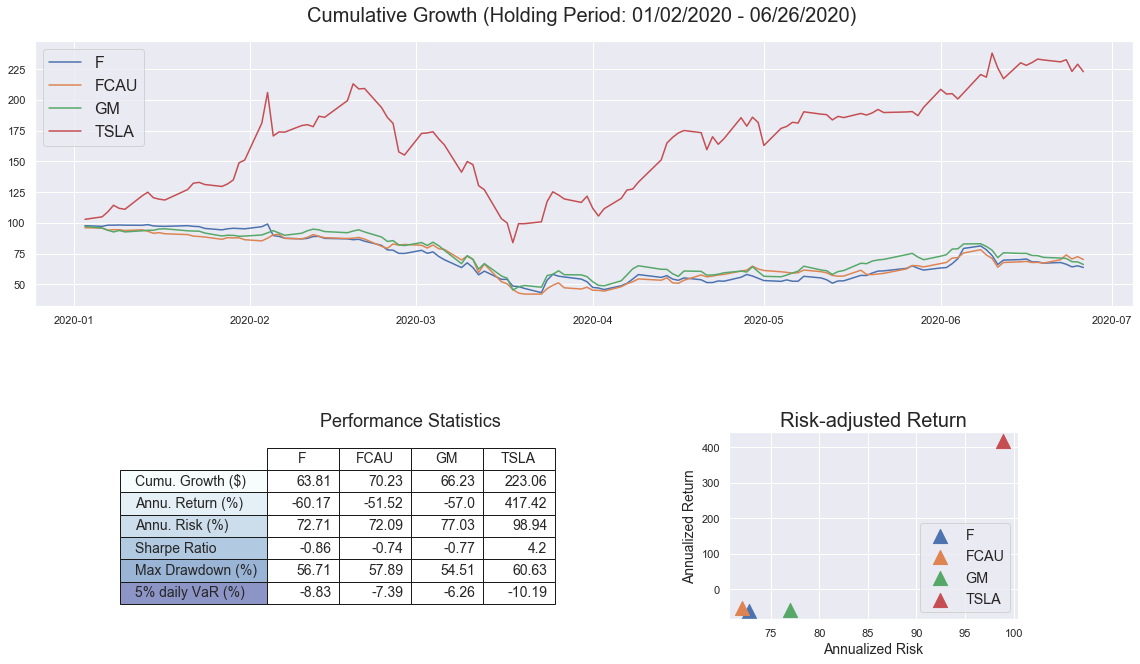

In [12]:
if __name__ == "__main__": 
#     ticker_list = input("Please input valid tickers: ")
#     ticker_list = "MSFT BABA AAPL GOOG FB AMZN"
    ticker_list='TSLA GM F FCAU'
    main(ticker_list) 

## <center> The End! </center>